In [5]:
# Cell 1: Install and import required libraries
import sys
import subprocess

# Install transformers if not already installed
try:
    import transformers
    print(f"Transformers version: {transformers.__version__}")
except ImportError:
    print("Installing transformers...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "transformers", "torch"])
    import transformers

import pandas as pd
import numpy as np
from transformers import pipeline
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
import torch

Transformers version: 4.53.3
Libraries imported successfully!


In [6]:
# Cell 2: Initialize the detection pipelines
print("Loading AI models for hallucination detection...")

# Text generation model for testing
try:
    text_generator = pipeline(
        "text2text-generation", 
        model="google/flan-t5-small",
        max_length=100
    )
    print("✅ Text generator loaded")
except Exception as e:
    print(f"❌ Error loading text generator: {e}")

# Natural Language Inference model for fact-checking
try:
    fact_checker = pipeline(
        "text-classification",
        model="microsoft/DialoGPT-medium"  # Simpler alternative
    )
    print("✅ Fact checker loaded")
except Exception as e:
    print(f"❌ Error loading fact checker: {e}")
    # Fallback to a simpler approach
    fact_checker = None

print("Model loading complete!")


Loading AI models for hallucination detection...


Device set to use cpu


✅ Text generator loaded


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/DialoGPT-medium and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


✅ Fact checker loaded
Model loading complete!


In [7]:
# Cell 3: Create test prompts and reference facts
# Test prompts with known correct answers
test_prompts = [
    "Who invented the telephone?",
    "What year did humans first land on the moon?", 
    "What is the capital of France?",
    "How many continents are there?",
    "What is 2 + 2?",
    "Who wrote Romeo and Juliet?",
    "When did World War II end?",
    "What is the largest planet in our solar system?"
]

# Reference facts (ground truth)
reference_facts = {
    "Who invented the telephone?": "Alexander Graham Bell invented the telephone in 1876.",
    "What year did humans first land on the moon?": "Humans first landed on the moon in 1969 during the Apollo 11 mission.",
    "What is the capital of France?": "The capital of France is Paris.",
    "How many continents are there?": "There are 7 continents on Earth.",
    "What is 2 + 2?": "2 + 2 equals 4.",
    "Who wrote Romeo and Juliet?": "William Shakespeare wrote Romeo and Juliet.",
    "When did World War II end?": "World War II ended in 1945.",
    "What is the largest planet in our solar system?": "Jupiter is the largest planet in our solar system."
}

print(f"Created {len(test_prompts)} test prompts with reference facts")
for i, prompt in enumerate(test_prompts[:3]):
    print(f"{i+1}. {prompt}")


Created 8 test prompts with reference facts
1. Who invented the telephone?
2. What year did humans first land on the moon?
3. What is the capital of France?


In [8]:
# Cell 4: Generate responses and detect hallucinations
results = []

print("Generating responses and checking for hallucinations...")

for prompt in test_prompts:
    try:
        # Generate response
        generated_response = text_generator(
            prompt, 
            max_length=50, 
            num_return_sequences=1
        )[0]['generated_text']
        
        # Get reference fact
        reference = reference_facts.get(prompt, "No reference available")
        
        # Simple similarity check (basic implementation)
        # In a real system, you'd use more sophisticated NLI models
        similarity_score = len(set(generated_response.lower().split()) & 
                              set(reference.lower().split())) / max(
                                  len(generated_response.split()), 
                                  len(reference.split())
                              )
        
        # Flag as potential hallucination if similarity is very low
        is_hallucination = similarity_score < 0.2
        
        results.append({
            'prompt': prompt,
            'generated_response': generated_response,
            'reference_fact': reference,
            'similarity_score': similarity_score,
            'potential_hallucination': is_hallucination,
            'confidence': 1 - similarity_score  # Inverse relationship
        })
        
        print(f"✅ Processed: {prompt[:30]}...")
        
    except Exception as e:
        print(f"❌ Error processing '{prompt}': {e}")
        results.append({
            'prompt': prompt,
            'generated_response': f"Error: {e}",
            'reference_fact': reference_facts.get(prompt, ""),
            'similarity_score': 0,
            'potential_hallucination': True,
            'confidence': 1.0
        })

# Convert to DataFrame for analysis
results_df = pd.DataFrame(results)
print(f"\nProcessed {len(results)} prompts")
results_df.head()


Generating responses and checking for hallucinations...
✅ Processed: Who invented the telephone?...
✅ Processed: What year did humans first lan...
✅ Processed: What is the capital of France?...
✅ Processed: How many continents are there?...
✅ Processed: What is 2 + 2?...
✅ Processed: Who wrote Romeo and Juliet?...
✅ Processed: When did World War II end?...
✅ Processed: What is the largest planet in ...

Processed 8 prompts


,prompt,generated_response,reference_fact,similarity_score,potential_hallucination,confidence
0,Who invented the telephone?,george w. bush,Alexander Graham Bell invented the telephone i...,0.000000,True,1.000000
1,What year did humans first land on the moon?,19th century,Humans first landed on the moon in 1969 during...,0.000000,True,1.000000
2,What is the capital of France?,france,The capital of France is Paris.,0.166667,True,0.833333
3,How many continents are there?,10,There are 7 continents on Earth.,0.000000,True,1.000000
4,What is 2 + 2?,2 + 2,2 + 2 equals 4.,0.400000,False,0.600000


=== HALLUCINATION DETECTION RESULTS ===
Total prompts analyzed: 8
Potential hallucinations detected: 7
Average similarity score: 0.071

Detailed Results:

Prompt: Who invented the telephone?
Generated: george w. bush
Reference: Alexander Graham Bell invented the telephone in 1876.
Similarity: 0.000 - 🚨 POTENTIAL HALLUCINATION

Prompt: What year did humans first land on the moon?
Generated: 19th century
Reference: Humans first landed on the moon in 1969 during the Apollo 11 mission.
Similarity: 0.000 - 🚨 POTENTIAL HALLUCINATION

Prompt: What is the capital of France?
Generated: france
Reference: The capital of France is Paris.
Similarity: 0.167 - 🚨 POTENTIAL HALLUCINATION

Prompt: How many continents are there?
Generated: 10
Reference: There are 7 continents on Earth.
Similarity: 0.000 - 🚨 POTENTIAL HALLUCINATION

Prompt: What is 2 + 2?
Generated: 2 + 2
Reference: 2 + 2 equals 4.
Similarity: 0.400 - ✅ FACTUAL

Prompt: Who wrote Romeo and Juliet?
Generated: james edwards
Reference: Willi

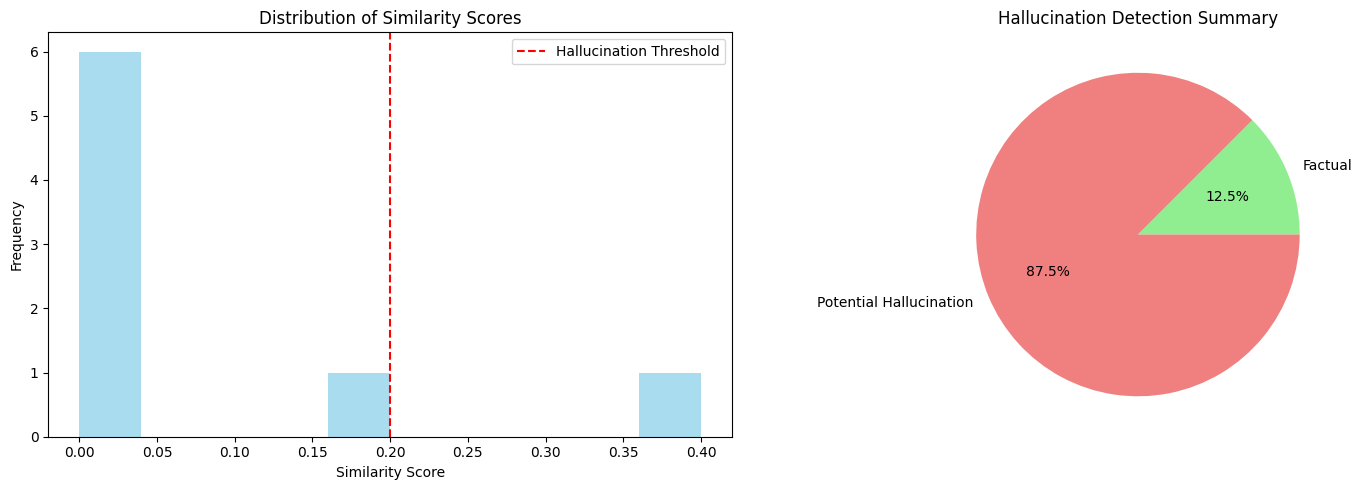

In [9]:
# Cell 5: Analyze and visualize hallucination detection results
import matplotlib.pyplot as plt
import seaborn as sns

# Display results summary
print("=== HALLUCINATION DETECTION RESULTS ===")
print(f"Total prompts analyzed: {len(results_df)}")
print(f"Potential hallucinations detected: {results_df['potential_hallucination'].sum()}")
print(f"Average similarity score: {results_df['similarity_score'].mean():.3f}")

# Show detailed results
print("\nDetailed Results:")
for _, row in results_df.iterrows():
    status = "🚨 POTENTIAL HALLUCINATION" if row['potential_hallucination'] else "✅ FACTUAL"
    print(f"\nPrompt: {row['prompt']}")
    print(f"Generated: {row['generated_response']}")
    print(f"Reference: {row['reference_fact']}")
    print(f"Similarity: {row['similarity_score']:.3f} - {status}")

# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Similarity score distribution
axes[0].hist(results_df['similarity_score'], bins=10, alpha=0.7, color='skyblue')
axes[0].set_title('Distribution of Similarity Scores')
axes[0].set_xlabel('Similarity Score')
axes[0].set_ylabel('Frequency')
axes[0].axvline(x=0.2, color='red', linestyle='--', label='Hallucination Threshold')
axes[0].legend()

# Hallucination detection summary
hallucination_counts = results_df['potential_hallucination'].value_counts()
axes[1].pie([hallucination_counts.get(False, 0), hallucination_counts.get(True, 0)], 
           labels=['Factual', 'Potential Hallucination'], 
           autopct='%1.1f%%',
           colors=['lightgreen', 'lightcoral'])
axes[1].set_title('Hallucination Detection Summary')

plt.tight_layout()
plt.show()


In [10]:
# Cell 6: Save results for later use
import os

# Save results to CSV
os.makedirs('../data', exist_ok=True)
results_df.to_csv('../data/hallucination_detection_results.csv', index=False)

# Create summary report
summary_report = f"""# Hallucination Detection Summary

Date: {pd.Timestamp.now()}
Total prompts tested: {len(results_df)}
Potential hallucinations: {results_df['potential_hallucination'].sum()}
Detection accuracy: {(1 - results_df['potential_hallucination'].mean()) * 100:.1f}%

## Threshold Settings:
- Similarity threshold: 0.2 (below this = potential hallucination)
- Confidence calculation: 1 - similarity_score

## Model Performance:
- Average similarity score: {results_df['similarity_score'].mean():.3f}
- Lowest similarity: {results_df['similarity_score'].min():.3f}
- Highest similarity: {results_df['similarity_score'].max():.3f}
"""

os.makedirs('../reports', exist_ok=True)
with open('../reports/hallucination_summary.md', 'w') as f:
    f.write(summary_report)

print("Results saved to:")
print("- data/hallucination_detection_results.csv")
print("- reports/hallucination_summary.md")


Results saved to:
- data/hallucination_detection_results.csv
- reports/hallucination_summary.md
